This notebook serves as test file while I'm implementing a routine to compute scaling constants for a given set of GlacierDirectories.

In [139]:
path = '/Users/oberrauch/work/master/data/scaling_params/run_output_constant_vas.nc'
import pickle
ds = pickle.load(open(path, mode='rb'))

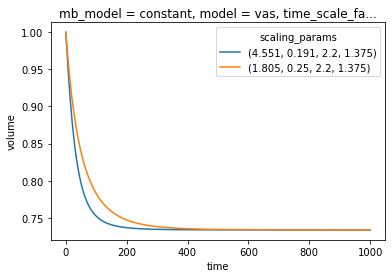

In [145]:
ds.sel(normalized=True, time_scale_factor=1).isel(scaling_params=slice(0,2x)).volume.plot.line(x='time')

In [147]:
[f'tmp{rid:05d}' for rid in [1459, 2077, 129]]

['tmp01459', 'tmp02077', 'tmp00129']

In [87]:
ds = ds.isel(scaling_params=1, drop=True)

In [109]:
import matplotlib.pyplot as plt

(100000000000.0, 300000000000.0)

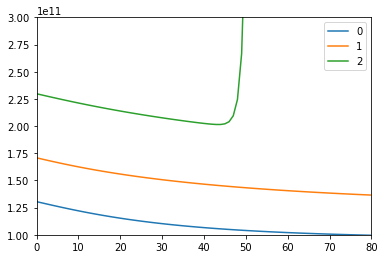

In [132]:
for i in range(3):
    plt.plot(ds.sel(normalized=False, time_scale_factor=1).isel(scaling_const=i, scaling_params=abs(2-i)).volume, label=i)
    
plt.legend()
plt.xlim([0,80])
plt.ylim([1e11,3e11])

In [85]:
ds.isel(scaling_params=1, drop=True)

<xarray.Dataset>
Dimensions:            (normalized: 2, scaling_const: 3, time: 1001, time_scale_factor: 1)
Coordinates:
    calendar_year      (time) int64 -1 0 1 2 3 4 5 ... 994 995 996 997 998 999
    calendar_month     (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
    mb_model           <U8 'constant'
    hydro_month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    model              <U3 'vas'
    hydro_year         (time) int64 0 1 2 3 4 5 6 ... 995 996 997 998 999 1000
  * time_scale_factor  (time_scale_factor) int64 1
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 998.0 999.0 1e+03
  * normalized         (normalized) object False True
Dimensions without coordinates: scaling_const
Data variables:
    volume             (normalized, scaling_const, time_scale_factor, time) float64 ...
    area               (normalized, scaling_const, time_scale_factor, time) float64 ...
    length             (normalized, scaling_const, time_scale_factor, time) float64 ...
    ela                (normalized, scaling_const, time_scale_factor, time) float64 ...

In [82]:
ds.drop_sel(scaling_params=1)

AttributeError: 'Dataset' object has no attribute 'drop_isel'

In [72]:
ds['scaling_const'] = ds.scaling_params

<xarray.Dataset>
Dimensions:            (normalized: 2, scaling_const: 3, scaling_params: 3, time: 1001, time_scale_factor: 1)
Coordinates:
    calendar_year      (time) int64 -1 0 1 2 3 4 5 ... 994 995 996 997 998 999
    calendar_month     (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
    mb_model           <U8 'constant'
    hydro_month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    model              <U3 'vas'
    hydro_year         (time) int64 0 1 2 3 4 5 6 ... 995 996 997 998 999 1000
  * time_scale_factor  (time_scale_factor) int64 1
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 998.0 999.0 1e+03
  * normalized         (normalized) object False True
    scaling_const      (scaling_params) object (0.244, 0.117, 2.517, 1.441) ....
Dimensions without coordinates: scaling_params
Data variables:
    volume             (normalized, scaling_const, scaling_params, time_scale_factor, time) float64 ...
    area               (normalized, scaling_const, scaling_params, time_scale_factor, time) float64 ...
    length             (normalized, scaling_const, scaling_params, time_scale_factor, time) float64 ...
    ela                (normalized, scaling_const, scaling_params, time_scale_factor, time) float64 ...

In [64]:
ds.('scaling_const')

ValueError: One or more of the specified variables cannot be found in this dataset

In [56]:
ds.sel(normalized=True, time_scale_factor=1).volume.plot.line(hue='scaling_const')

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

In [2]:
""" Sensitivity runs
--------------------

This script runs the VAS and flowline model for a single (or more) glacier(s)
with a constant or random massbalance model, performing sensitivity experiments

-> sensitivity to scaling constant
-> sensitivity to time scales

"""

# import externals libraries
import os
import json
import pickle
import numpy as np
import pandas as pd
import xarray as xr

import logging
log = logging.getLogger('sensitivity-runs')

# import the needed OGGM modules
from oggm import cfg, utils, workflow
from oggm.core import gis, climate, flowline
import oggm_vas as vascaling


def recursive_round(li, precision=3):
    """Rounds nested lists and returns in same structure"""
    try:
        return round(li, precision)
    except TypeError:
        return type(li)(recursive_round(x, precision) for x in li)


def normalize_ds_with_start(ds, store_var_0=False):
    """ Normalize all data variables of the given xarray Dataset
    with their respective first entry. Returns a new xarray.Dataset.

    Parameters
    ----------
    ds: :py:class:`xarray.Dataset`

    Returns
    -------
    Normalized xarray Dataset

    """
    # copy dataset
    ds_norm = ds.copy(deep=True)

    # iterate over all data variables
    for var in ds_norm:
        # add information about the initial values
        var_0 = ds_norm[var].isel(time=0)
        if store_var_0:
            ds_norm[var + '_0'] = var_0
        # normalize dataset
        ds_norm[var] /= var_0

    return ds_norm

In [10]:
# define glacier and paths
rgi_ids = ['RGI60-11.00897']
os.environ['WORKDIR'] = '/Users/oberrauch/work/master/working_directories/test_scaling_const'
os.environ['OUTDIR'] = '/Users/oberrauch/work/master/data/test_scaling_const'

# default function parameters
use_random_mb=False; use_mean=False;
path=True; temp_bias=0; tstar=None;
use_default_tstar=True; use_bias_for_run=True;
scaling_constants=[(4.5507, 0.191)];
scaling_exponents=[(2.2, 1.375)];
time_scale_factors=[1];
suffixes=['_default'];
kwargs = dict();

In [11]:
""" The routine runs all steps for the equilibrium experiments using the
volume/area scaling model (cf. `equilibrium_run_vas`) but for only one
given temperature bias. However, it is possible to supply a list of
sensitivity parameters (the scaling constants, and time scale factor) to
alter the model behavior.
- OGGM preprocessing, including initialization, GIS tasks, climate tasks and
  massbalance tasks.
- Run model for all glaciers with constant (or random) massbalance model
  over 3000 years (default value).
- Process the model output dataset(s), i.e. normalization, average/sum, ...

The final dataset containing all results is returned. Given a path is is
also stored to file.

Parameters
----------
rgi_ids: array-like
    List of RGI IDs for which the equilibrium experiments are performed.
use_random_mb: bool, optional, default=True
    Choose between random massbalance model and constant massbalance model.
use_mean: bool, optional, default=False
    Choose between the mean or summation over all glaciers
path: bool or str, optional, default=True
    If a path is given (or True), the resulting dataset is stored to file.
temp_bias: float, optional, default=0
    Temperature bias (degC) for the mass balance model.
sensitivity_constants: multi-dimensional array-like, optional,
    default=[(4.5507, 0.191)]
    List containing the scaling constants for length and area scaling as
    tuples
sensitivity_params: multi-dimensional array-like, optional,
    default=[(2.2, 1.375)]
    List containing the scaling exponents for length and area scaling as
    tuples
suffixes: array-like, optional, default=['default']
    Descriptive suffixes corresponding to the given sensitivity params
tstar: float, optional, default=None
    'Equilibrium year' used for the mass balance calibration.
use_default_tstar: bool, optional, default=True
    Flag deciding whether or not to compute mustar from given from reference
    table. Overridden by a given tstar.
use_bias_for_run: bool, optional, default=True
    Flag deciding whether or not to use the mass balance residual.
kwargs:
    Additional key word arguments for the `run_random_climate` or
    `run_constant_climate` routines of the vascaling module.

Returns
-------
Dataset containing yearly values of all glacier geometries.

"""
# assert correct output file suffixes for temp biases
if len(scaling_constants) * len(scaling_constants) \
        * len(time_scale_factors) != len(suffixes):
    raise RuntimeError("Each given combination of scaling parameters and "
                       "time scale factor must have its corresponding"
                       "suffix.")

# OGGM preprocessing
# ------------------

# compute RGI region and version from RGI IDs
# assuming all they are all the same
rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:-1]

# load default parameter file
cfg.initialize()

# get environmental variables for working and output directories
WORKING_DIR = os.environ["WORKDIR"]
OUTPUT_DIR = os.environ["OUTDIR"]
# create working directory
utils.mkdir(WORKING_DIR)
# set path to working directory
cfg.PATHS['working_dir'] = WORKING_DIR
# set RGI version and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = use_bias_for_run

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True
# operational run, all glaciers should run
cfg.PARAMS['continue_on_error'] = True

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_directories(rgidf, reset=False, force=True)

# define the local grid and glacier mask
workflow.execute_entity_task(gis.define_glacier_region, gdirs)
workflow.execute_entity_task(gis.glacier_masks, gdirs)
# process the given climate file
workflow.execute_entity_task(climate.process_climate_data, gdirs)
# compute local t* and the corresponding mu*
if tstar or use_default_tstar:
    # compute mustar from given tstar or reference table
    workflow.execute_entity_task(vascaling.local_t_star, gdirs, tstar=tstar, bias=0)
else:
    # compute mustar from the reference table for the flowline model
    # RGI v6 and HISTALP baseline climate
    ref_df = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'))
    workflow.execute_entity_task(vascaling.local_t_star, gdirs, ref_df=ref_df)

# Run model with constant/random mass balance model
# -------------------------------------------------

# use t* as center year, even if specified differently
kwargs['y0'] = tstar
# run for 3000 years if not specified otherwise
kwargs.setdefault('nyears', 3000)

# limit parameters to 3 decimal points
scaling_constants = recursive_round(scaling_constants, 3)
time_scale_factors = recursive_round(time_scale_factors, 3)
# assure that scaling params are handled as tuples (pairs)
scaling_constants_list = np.zeros(len(scaling_constants), dtype=object)
scaling_constants_list[:] = scaling_constants
scaling_exponents_list = np.zeros(len(scaling_exponents), dtype=object)
scaling_exponents_list[:] = scaling_exponents
# combine scaling constants, scaling exponents and time scale factor
# into one iterable array
sensitivity_params = np.array(np.meshgrid(scaling_constants_list,
                                          scaling_exponents_list,
                                          time_scale_factors)).T
sensitivity_params = (sensitivity_params
                      .reshape(-1, sensitivity_params.shape[-1]))

if use_random_mb:
    # set random seed to get reproducible results
    kwargs.setdefault('seed', 12)

    # run RandomMassBalance model centered around t* for each given
    # parameter set
    for suffix, params in zip(suffixes, sensitivity_params):
        cfg.PARAMS['vas_c_length_m'] = params[0][0]
        cfg.PARAMS['vas_c_area_m2'] = params[0][1]
        cfg.PARAMS['vas_q_length'] = params[1][0]
        cfg.PARAMS['vas_gamma_area'] = params[1][1]
        kwargs['time_scale_factor'] = params[2]
        workflow.execute_entity_task(vascaling.run_random_climate, gdirs,
                                     temperature_bias=temp_bias,
                                     output_filesuffix=suffix, **kwargs)
else:
    # run ConstantMassBalance model centered around t* for each given
    # parameter set
    for suffix, params in zip(suffixes, sensitivity_params):
        cfg.PARAMS['vas_c_length_m'] = params[0][0]
        cfg.PARAMS['vas_c_area_m2'] = params[0][1]
        cfg.PARAMS['vas_q_length'] = params[1][0]
        cfg.PARAMS['vas_gamma_area'] = params[1][1]
        kwargs['time_scale_factor'] = params[2]
        workflow.execute_entity_task(vascaling.run_constant_climate, gdirs,
                                     temperature_bias=temp_bias,
                                     output_filesuffix=suffix, **kwargs)

2020-09-25 11:51:15: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-09-25 11:51:15: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-09-25 11:51:15: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-09-25 11:51:16: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `6`.
2020-09-25 11:51:16: oggm.cfg: PARAMS['border'] changed from `20` to `120`.
2020-09-25 11:51:16: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-09-25 11:51:16: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-09-25 11:51:16: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-09-25 11:51:17: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2020-09-25 11:51:17: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers
2020-09-25 11:51:18: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-09-25 11:51:18: oggm.co

In [24]:
xr.concat(ds__, dim='time_scale_factor')

<xarray.Dataset>
Dimensions:            (rgi_id: 1, time: 3001, time_scale_factor: 1)
Coordinates:
    calendar_month     (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 -1 0 1 2 3 4 ... 2995 2996 2997 2998 2999
    hydro_month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year         (time) int64 0 1 2 3 4 5 ... 2996 2997 2998 2999 3000
  * rgi_id             (rgi_id) <U14 'RGI60-11.00897'
  * time               (time) float64 0.0 1.0 2.0 ... 2.998e+03 2.999e+03 3e+03
  * time_scale_factor  (time_scale_factor) int64 1
Data variables:
    volume             (time_scale_factor, time, rgi_id) float64 5.963e+08 .....
    area               (time_scale_factor, time, rgi_id) float64 8.036e+06 .....
    length             (time_scale_factor, time, rgi_id) float64 4.894e+03 .....
    ela                (time_scale_factor, time, rgi_id) float64 nan nan ... nan
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-09-25 09:55:19

In [29]:
dim={'scaling_expo': expo}
dim

{'scaling_expo': (2.2, 1.375)}

In [28]:
ds__.expand_dims()

<xarray.Dataset>
Dimensions:            (rgi_id: 1, time: 3001, time_scale_factor: 1)
Coordinates:
    calendar_month     (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 -1 0 1 2 3 4 ... 2995 2996 2997 2998 2999
    hydro_month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year         (time) int64 0 1 2 3 4 5 ... 2996 2997 2998 2999 3000
  * rgi_id             (rgi_id) <U14 'RGI60-11.00897'
  * time               (time) float64 0.0 1.0 2.0 ... 2.998e+03 2.999e+03 3e+03
  * time_scale_factor  (time_scale_factor) int64 1
Data variables:
    volume             (time_scale_factor, time, rgi_id) float64 5.963e+08 .....
    area               (time_scale_factor, time, rgi_id) float64 8.036e+06 .....
    length             (time_scale_factor, time, rgi_id) float64 4.894e+03 .....
    ela                (time_scale_factor, time, rgi_id) float64 nan nan ... nan
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-09-25 09:57:49

In [25]:
# Process output dataset(s)
# -------------------------

# create empty container
ds = list()
# iterate over all scaling constants
for i, consts in enumerate(scaling_constants):
    # create empty container
    ds_ = list()
    # iterate over all scaling exponents
    for j, expo in enumerate(scaling_exponents):
        # create empty container
        ds__ = list()
        # iterate over all time scale factor
        for k, factor in enumerate(time_scale_factors):
            # compile the output for each run
            pos = k + len(time_scale_factors)*j \
                  + len(time_scale_factors) * len(scaling_exponents) * i
            ds___ = utils.compile_run_output(np.atleast_1d(gdirs),
                                             filesuffix=suffixes[pos],
                                             path=False)
            # add time scale factor as coordinate
            ds___.coords['time_scale_factor'] = factor
            # add to container
            ds__.append(ds___)
        
        # concatenate using time scale factor as concat dimension
        ds__ = xr.concat(ds__, dim='time_scale_factor')
        # add scaling exponent as dimesion
        ds__ = ds__.expand_dims(dim={'scaling_expo': expo})
        # add to container
        ds_.append(ds__)
    
    # add to container
    ds.append(ds_)

2020-09-25 11:57:49: oggm.utils: Applying compile_run_output on 1 gdirs.


ValueError: dimensions ('scaling_expo',) must have the same length as the number of data dimensions, ndim=0

In [19]:
ds

[[[<xarray.Dataset>
   Dimensions:            (rgi_id: 1, time: 3001)
   Coordinates:
     * time               (time) float64 0.0 1.0 2.0 ... 2.998e+03 2.999e+03 3e+03
     * rgi_id             (rgi_id) <U14 'RGI60-11.00897'
       hydro_year         (time) int64 0 1 2 3 4 5 ... 2996 2997 2998 2999 3000
       hydro_month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
       calendar_year      (time) int64 -1 0 1 2 3 4 ... 2995 2996 2997 2998 2999
       calendar_month     (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
       time_scale_factor  int64 1
   Data variables:
       volume             (time, rgi_id) float64 5.963e+08 5.957e+08 ... 5.669e+08
       area               (time, rgi_id) float64 8.036e+06 8.036e+06 ... 7.746e+06
       length             (time, rgi_id) float64 4.894e+03 4.894e+03 ... 4.783e+03
       ela                (time, rgi_id) float64 nan nan nan nan ... nan nan nan
   Attributes:
       description:    OGGM model output
       og

In [ ]:
        # concatenate using time scale factor as concat dimension
        ds__ = xr.concat(ds__, dim='time_scale_factor')
        # add scaling exponent as dimesion
        ds_ = ds_.expand_dims(dim={'scaling_const': consts_list})

    # concatenate using time scale factor as concat dimension
    ds_ = xr.concat(ds_, dim='time_scale_factor')
    # add scaling constants as coordinate
    consts_list = np.zeros(len([consts]), dtype=object)
    consts_list[:] = [consts]
    ds_ = ds_.expand_dims(dim={'scaling_const': consts_list})
    # ds_.coords['area_scaling_const'] = consts[1]
    # add to container
    ds.append(ds_)

# concatenate using scaling constants as concat dimension
# ds = xr.concat(ds, dim='area_scaling_const')
ds = xr.concat(ds, dim='scaling_const')

# add model type as coordinate
ds.coords['model'] = 'vas'
# add mb model type as coordinate
ds.coords['mb_model'] = 'random' if use_random_mb else 'constant'

# normalize glacier geometries (length/area/volume) with start value
if use_mean:
    # compute average over all glaciers
    ds_normal = normalize_ds_with_start(ds).mean(dim='rgi_id')
    ds = ds.mean(dim='rgi_id')
else:
    # compute sum over all glaciers
    ds_normal = normalize_ds_with_start(ds.sum(dim='rgi_id'))
    ds = ds.sum(dim='rgi_id')

# add coordinate to distinguish between normalized and absolute values
ds.coords['normalized'] = False
ds_normal.coords['normalized'] = True

# combine datasets
ds = xr.concat([ds, ds_normal], 'normalized')

# store datasets
if path:
    if not isinstance(path, str):
        # set default path and filename
        mb = 'random' if use_random_mb else 'constant'
        path = os.path.join(OUTPUT_DIR, f'run_output_{mb}_vas.nc')
        pickle.dump(ds, open(path, mode='wb'))


In [14]:
vascaling.run_constant_climate(gdirs[0])

2020-09-25 11:44:58: oggm_vas.core: (RGI60-11.00897) run_constant_climate
2020-09-25 11:44:58: oggm_vas.core: TypeError occurred during task run_constant_climate on RGI60-11.00897: run_until() got an unexpected keyword argument 'time_scale_factor'


In [30]:
scaling_params=[(4.5507, 0.191, 2.2, 1.375)]
time_scale_factors=[1]
# assure that scaling params are handled as tuples (pairs)
scaling_params_list = np.zeros(len(scaling_params), dtype=object)
scaling_params_list[:] = scaling_params
# combine scaling constants, scaling exponents and time scale factor
# into one iterable array
sensitivity_params = np.array(np.meshgrid(scaling_params_list,
                                          time_scale_factors)).T
sensitivity_params = (sensitivity_params
                      .reshape(-1, sensitivity_params.shape[-1]))

In [33]:
for p in sensitivity_params:
    print(p[0])

(4.5507, 0.191, 2.2, 1.375)


In [48]:
def recursive_round(li, precision=3):
    """Rounds nested lists and returns in same structure"""
    try:
        return round(li, precision)
    except TypeError:
        return type(li)(recursive_round(x, precision) for x in li)

In [49]:
scaling_params_dict = json.load(open('/Users/oberrauch/work/master/data/scaling_params/scaling_params.json'))

# set scaling parameters
scaling_params_list = [(4.551, 0.191, 2.2, 1.375)]  # Global
const_only = list(scaling_params_dict['const_only'].values())
const_only.extend([2.2, 1.375])
scaling_params_list.append(tuple(const_only))  # consts only
scaling_params_list.append(tuple(list(scaling_params_dict['const_expo'].values())[:4]))  # best fit

In [51]:
recursive_round(scaling_params_list)

[(4.551, 0.191, 2.2, 1.375),
 (1.805, 0.25, 2.2, 1.375),
 (0.244, 0.117, 2.517, 1.441)]

In [53]:
scaling_params = np.zeros(len(scaling_params_list), dtype=object)
scaling_params[:] = scaling_params_list


TypeError: expected sequence object with len >= 0 or a single integer